<a href="https://colab.research.google.com/github/ogilg/Algorithms-DataStructures/blob/main/Oversmoothing_in_GATs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Over-smoothing in GAT and Multi-Hop GAT

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import sys
import os

sys.path.append(os.path.join('/content','gdrive','My Drive','Oxford', 'Year 4','GRL','MP','GNN-MAGNA'))
sys.path.append(os.path.join('/content','gdrive','My Drive','Oxford', 'Year 4','GRL','MP','GNN-MAGNA', 'MAGNA'))

In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu111.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.13.0+cu111.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu111.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu111.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu111.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-0krs8gwj
  Running command git clone -q https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-0krs8gwj
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install dgl-cu111

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import dgl.data

Using backend: pytorch


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import typing

In [ ]:
import torch_geometric
import torch_geometric.datasets as ds
from torch_geometric.nn import GCNConv, GATConv

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Standard GCN implementation

In [ ]:
class GCN(nn.Module):
  def __init__(
      self,
      input_dim: int,
      hid_dim: int,
      n_classes: int,
      n_layers: int,
      dropout_ratio: float = 0.3):
    super(GCN, self).__init__()
    """
    Args:
      input_dim: input feature dimension
      hid_dim: hidden feature dimension
      n_classes: number of target classes
      n_layers: number of layers
      dropout_ratio: dropout_ratio
    """
    ## ------ Begin Solution ------ ##
    self.dropout_ratio = dropout_ratio
    self.n_layers = n_layers

    layer_list = []

    if n_layers == 0:
      layer_list.append(nn.Linear(input_dim, n_classes))

    else:
      layer_list.append(GCNConv(input_dim, hid_dim))
      for l in range(n_layers-2):
        layer_list.append(GCNConv(hid_dim, hid_dim))
      layer_list.append(GCNConv(hid_dim, n_classes))

    self.layers = nn.ModuleList(layer_list)

  
    ## ------ End Solution ------ ##

  def forward(self, X, A) -> torch.Tensor:
    if self.n_layers == 0:
      X = self.layers[0](X)
      X = F.relu(X)
      X = F.dropout(X, self.dropout_ratio)

    else:
      for layer in self.layers:
        X = layer(X, A)
        X = F.relu(X)
        X = F.dropout(X, self.dropout_ratio)
    return X
    
  def generate_node_embeddings(self, X, A) -> torch.Tensor:
    embeddings = []
    for layer in self.layers[:-1]:
      X = layer(X, A)
      X = F.relu(X)
      X = F.dropout(X, self.dropout_ratio)
      embeddings.append(X)
    return embeddings
  
  def param_init(self):
    for layer in self.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
        elif hasattr(layer, 'children'):
            for child_layer in layer.children():
              child_layer.reset_parameters()


### GAT implementation

In [ ]:
class GAT(nn.Module):
  def __init__(
      self,
      input_dim: int,
      hid_dim: int,
      n_classes: int,
      n_layers: int,
      dropout_ratio: float = 0.):
    super(GAT, self).__init__()
    """
    Args:
      input_dim: input feature dimension
      hid_dim: hidden feature dimension
      n_classes: number of target classes
      n_layers: number of layers
      dropout_ratio: dropout_ratio
    """
    ## ------ Begin Solution ------ ##
    self.dropout_ratio = dropout_ratio
    self.n_layers = n_layers

    layer_list = []

    if n_layers == 0:
      layer_list.append(nn.Linear(input_dim, n_classes))

    else:
      layer_list.append(GATConv(input_dim, hid_dim))
      for l in range(n_layers-2):
        layer_list.append(GATConv(hid_dim, hid_dim))
      layer_list.append(GATConv(hid_dim, n_classes))

    self.layers = nn.ModuleList(layer_list)

  
    ## ------ End Solution ------ ##

  def forward(self, X, A) -> torch.Tensor:
    if self.n_layers == 0:
      X = self.layers[0](X)
      X = F.relu(X)
      X = F.dropout(X, self.dropout_ratio)

    else:
      for layer in self.layers:
        X = layer(X, A)
        X = F.relu(X)
        X = F.dropout(X, self.dropout_ratio)
    return X
    
  def generate_node_embeddings(self, X, A) -> torch.Tensor:
    embeddings = []
    for layer in self.layers[:-1]:
      X = layer(X, A)
      X = F.relu(X)
      X = F.dropout(X, self.dropout_ratio)
      embeddings.append(X)
    return embeddings
  
  def param_init(self):
    for layer in self.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
        elif hasattr(layer, 'children'):
            for child_layer in layer.children():
              child_layer.reset_parameters()


### Training code

In [ ]:
from torchmetrics import Accuracy

def evaluate(
    model,
    data,
    mask
):
   out = model(data.x, data.edge_index)
   accuracy = Accuracy(task='multiclass', num_classes=out.shape[1],top_k=1).to("cuda")
   val_accuracy = accuracy(out[mask], data.y[mask])
   return val_accuracy



def train_gnn(
    params: typing.Dict,
    dataset
) -> torch.nn.Module:
  """
    This function trains a node classification model and returns the trained model object.
  """
  # set device
  device = "cuda" if torch.cuda.is_available() else "cpu"

  # load dataset
  data = dataset.data
  data = data.to(device)

  # Update parameters
  params["n_classes"] = dataset.num_classes # number of target classes
  params["input_dim"] = dataset.num_features # size of input features

  # Set a model
  if params['model_name'] == 'GCN':
      model = GCN(
        params["input_dim"], 
        params["hid_dim"],
        params["n_classes"],
        params["n_layers"],
        params["dropout"]
        ).to(device)
  elif params['model_name'] == 'GAT':
      model = GAT(
        params["input_dim"], 
        params["hid_dim"],
        params["n_classes"],
        params["n_layers"]
      ).to(device)
  else:
      raise NotImplementedError
      
  model.param_init()

  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
  previous_acc = None
  increasing_acc_epochs = 0

  for i in range(params["epochs"]):
      # Zero your gradients for every batch!
      optimizer.zero_grad()

      # Make predictions for this batch
      outputs = model(data.x, data.edge_index)

      # Compute the loss and its gradients
      loss = loss_fn(outputs[data.train_mask], data.y[data.train_mask])
      loss.backward()

      # Adjust learning weights
      optimizer.step()

      acc = evaluate(model, data, data.val_mask)
      if previous_acc is not None and acc < previous_acc:
        increasing_acc_epochs += 1
      else:
        best_model = model
        best_acc = acc
        increasing_acc_epochs = 0

      if increasing_acc_epochs == params["max_patience"]:
        return best_model, best_acc
      else:
        previous_acc = acc

  return best_model, best_acc


### Datasets

In [287]:
import dgl.data

In [ ]:
cora_dataset = ds.Planetoid(
    root="./",
    name='Cora',
    split="public",
    transform=torch_geometric.transforms.GCNNorm()
  )

cora_graph = dgl.data.CoraGraphDataset()[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [ ]:
citeseer_dataset = ds.Planetoid(
    root="./",
    name='Citeseer',
    split="public",
    transform=torch_geometric.transforms.GCNNorm()
  )

citeseer_graph = dgl.data.CiteseerGraphDataset()[0]

  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [ ]:
pubmed_dataset = ds.Planetoid(
    root="./",
    name='Pubmed',
    split="public",
    transform=torch_geometric.transforms.GCNNorm()
  )

pubmed_graph = dgl.data.PubmedGraphDataset()[0]

  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


### GAT and standard GCN

In [ ]:
def compute_experiment_accuracies(dataset, training_params, depths, df):
  data = dataset.data.to("cuda")

  for num_layers in depths:
    print("Number of layers: ", num_layers)
    training_params["n_layers"] = num_layers

    training_params["model_name"] = 'GCN'
    training_params["dropout"] = 0.3

    for i in range(5):
      best_model = train_gnn(training_params, dataset)[0]
      acc = float(evaluate(best_model, data, data.test_mask))
      df = df.append(pd.DataFrame({"model": [training_params["model_name"]], "dataset": [dataset.name], "num_layers": [num_layers], "accuracy": [acc],  "num_hops": None}))
   
    training_params["dropout"] = 0.0

    for i in range(5):
      best_model = train_gnn(training_params, dataset)[0]
      acc = float(evaluate(best_model, data, data.test_mask))
      df = df.append(pd.DataFrame({"model": [training_params["model_name"]+"_no_dropout"], "dataset": [dataset.name], "num_layers": [num_layers], "accuracy": [acc], "num_hops": None}))

       
    training_params["model_name"] = 'GAT'
    for i in range(5):
      best_model = train_gnn(training_params, dataset)[0]
      acc = float(evaluate(best_model, data, data.test_mask))
      df = df.append(pd.DataFrame({"model": [training_params["model_name"]], "dataset": [dataset.name], "num_layers": [num_layers], "accuracy": [acc], "num_hops": None}))


  return df


### Multi-Hop GATs

In [ ]:
from codes.train import train

In [ ]:
def compute_magna_accuracies(dataset, data_graph, train_params, depths, df):
  df_copy = df.copy()
  data = dataset.data.to("cpu")
  print(data.x.shape)
  for num_layers in depths:
    print("Number of layers: ", num_layers)

    train_params["num_layers"] = num_layers

    accs = []
    for i in range(5):
      best_model, test_acc = train(train_params, data, data_graph)  
      df_copy = df_copy.append(pd.DataFrame({"model": ["MAGNA"], "dataset": [dataset.name], "num_layers": [num_layers], "accuracy": [test_acc], "num_hops": train_params["hop_num"]}))

  return df_copy

## Run Experiment

In [ ]:
depths = [1, 3, 5, 10, 15]
dataset = citeseer_dataset
dataset_graph = citeseer_graph

In [ ]:
training_params = {
    "lr": 0.005,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 100,  # number of total training epochs
    "max_patience": 5, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": None, # number of layers
    "model_name": "GAT",
    "dropout" : 0.3
}

# MAGNA
magna_train_params = {
    "lr": 0.005,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 100,  # number of total training epochs
    "max_patience": 5, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "num_layers": None, # number of layers
    "project_dim": 64,
    "in_drop":0,
    "attn_drop":0.3,
    "hop_num": 3,
    "model_name": "MAGNA",
    "self_loops":True,
    "num_heads": 8
    }


In [ ]:
df = pd.DataFrame(columns=["model", "num_layers", "accuracy", "dataset", "num_hops"])

In [ ]:
datasets = [cora_dataset, citeseer_dataset, pubmed_dataset]
dataset_graphs = [cora_graph, citeseer_graph, pubmed_graph]

In [ ]:
for i in range(3):
  dataset = datasets[i]
  dataset_graph = dataset_graphs[i]
  df = compute_magna_accuracies(dataset, dataset_graph, magna_train_params, depths, df)
  df = compute_experiment_accuracies(dataset, training_params, depths, df)


In [ ]:
df = compute_experiment_accuracies(dataset, training_params, depths, df)

In [ ]:
df = compute_magna_accuracies(dataset, dataset_graph, magna_train_params, depths, df)

In [ ]:
df["num_hops"] = np.where(df.model == "MAGNA", 3, None)

In [ ]:
df.to_pickle("./stats03.pkl") 

In [ ]:
df.model.unique()

array(['MAGNA', 'GCN', 'GCN_no_dropout', 'GAT'], dtype=object)

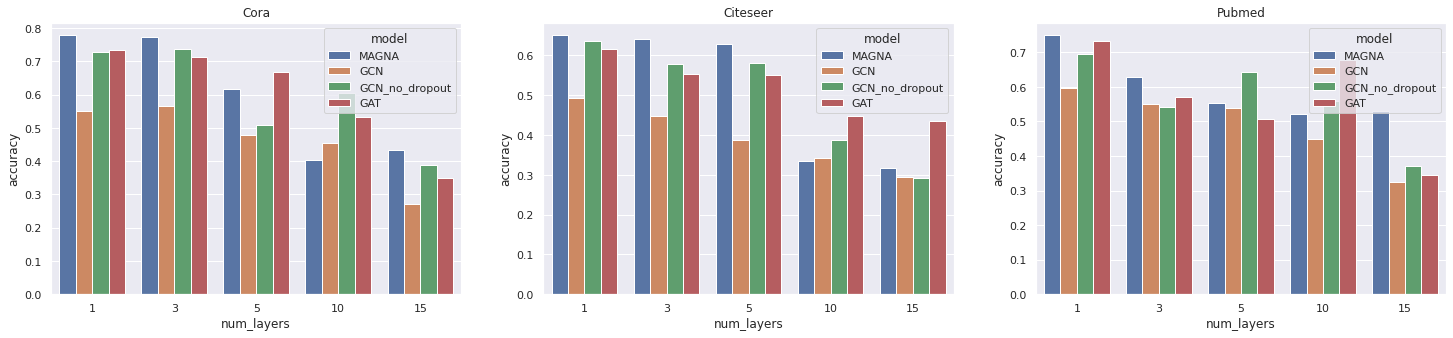

In [288]:
sns.set(rc={'figure.figsize':(25,5)})
fig, axs = plt.subplots(1,3)
for i, ds in enumerate(["Cora", "Citeseer", "Pubmed"]):
  sns.barplot(data=df[df.dataset == ds], x="num_layers", y="accuracy", hue="model", hue_order=df.model.unique(), ci=None, ax = axs[i]).set_title(ds)

## Where does over-smoothing begin for MAGNA

In [ ]:
magna_train_params["hop_num"] = 3

In [289]:
hops = [3, 6, 9]

In [290]:
df_deep = pd.DataFrame(columns=["model", "num_layers", "accuracy", "dataset","num_hops"])

In [295]:
for num_hops in hops:
  magna_train_params["hop_num"] = num_hops
  df_deep = compute_magna_accuracies(dataset, dataset_graph, magna_train_params, [3,5,10, 20], df_deep)

EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
torch.Size([19717, 500])
Number of layers:  3
Ea

In [294]:
df_deep.num_hops.unique()

array([3], dtype=object)

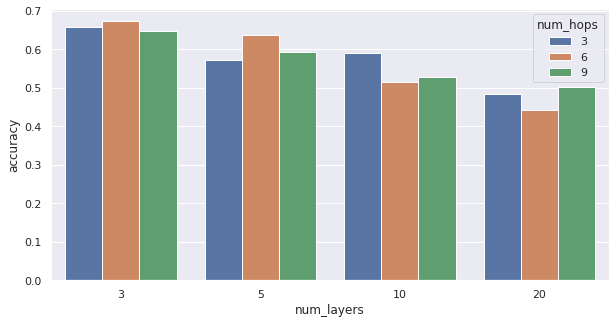

In [296]:
sns.set(rc={'figure.figsize':(10,5)})
sns.barplot(data=df_deep[df_deep.model == "MAGNA"], x="num_layers", y="accuracy", hue="num_hops", ci=None)

# MAD

In [ ]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

def compute_mad(feature_matrix):
  l = feature_matrix.size(0)
  D = compute_cosine_similarity_matrix(feature_matrix)

  avg_D = torch.empty((l))

  for i in range(l):
    avg_D[i] = torch.sum(D[i])/ torch.sum(D[i]> 0)

  mad = torch.sum(avg_D)/ torch.sum(avg_D> 0)

  return mad



def compute_cosine_similarity_matrix(feature_matrix):
  l = feature_matrix.size(0)
  D = torch.empty((l,l))
  computed = []
  for i in range(l):
    for j in range(l):
      if (j, i) in computed:
        D[i,j] = D[j,i]
      else:
        D[i,j] = 1 - cos(feature_matrix[i], feature_matrix[j])
      computed.append((i,j))

  return D

    

In [ ]:
dataset = cora_dataset
data_graph = cora_graph

tensor(3.2500)

In [ ]:
X = dataset.data.x[:50]
magna_train_params["num_layers"] = 4
training_params["num_layer"] = 4

### GAT

In [ ]:
best_model = train_gnn(training_params, dataset)[0]

In [ ]:
best_model.generate_node_embeddings(X, dataset.data.edge_index)

### MAGNA

In [ ]:
best_model = train(magna_train_params, dataset.data, data_graph)[0] 

In [ ]:
best_model.layer_attention_node_features(X)

# Visualisation

In [ ]:
dataset = citeseer_dataset
dataset_graph = citeseer_graph

In [ ]:
magna_train_params["num_layers"] = 10
training_params["n_layers"] = 10

In [ ]:
training_params

{'lr': 0.005,
 'weight_decay': 0.0005,
 'epochs': 100,
 'max_patience': 5,
 'hid_dim': 64,
 'n_layers': 100,
 'model_name': 'GAT',
 'dropout': 0.0,
 'n_classes': 6,
 'input_dim': 3703,
 'num_layers': 4}

In [ ]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
def dimension_reduction(model: nn.Module, data) -> pd.DataFrame:
  """
    Args:
      model: model object for generating features
      data
    Return:
      pd.DataFrame: A data frame that has 'dimension 1', 'dimension 2', and 'labels' as a column
  """
  X_embedded = TSNE(n_components=2).fit_transform(model.generate_node_embeddings(data.x, data.edge_index)[-1].cpu().detach().numpy())
  return X_embedded

In [ ]:
def dimension_reduction_magna(model: nn.Module, data) -> pd.DataFrame:
  """
    Args:
      model: model object for generating features
      data
    Return:
      pd.DataFrame: A data frame that has 'dimension 1', 'dimension 2', and 'labels' as a column
  """
  
  embedding = model.layer_attention_node_features(data.x)[1][-1].cpu().detach().numpy()
  X_embedded = TSNE(n_components=2).fit_transform(embedding)
  return X_embedded

In [ ]:
gat_model = train_gnn(training_params, dataset)[0].to("cuda")

/usr/local/lib/python3.8/dist-packages/torch_geometric/data/in_memory_dataset.py:133: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn("It is not recommended to directly access the internal "


In [ ]:
magna_model = train(magna_train_params, dataset.data.to("cpu"), dataset_graph)[0] 

/usr/local/lib/python3.8/dist-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5


In [ ]:
feature_dict = {
    "gat": dimension_reduction(gat_model, dataset.data.to("cuda")),
    "magna": dimension_reduction_magna(magna_model,dataset.data)
}

/usr/local/lib/python3.8/dist-packages/torch_geometric/data/in_memory_dataset.py:133: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn("It is not recommended to directly access the internal "


In [ ]:
def visualise(feature_dict: typing.Dict) -> None:
  fig, axs = plt.subplots(1,2, figsize=(20,7))
  for i in range(2):
    embedding = feature_dict[list(feature_dict.keys())[i]]
    axs[i].scatter(embedding[:,0], embedding[:,1])

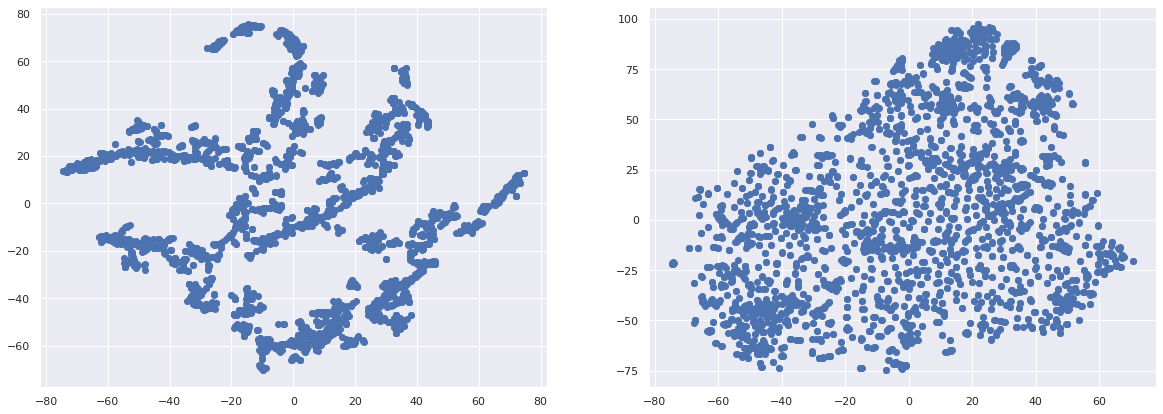

In [ ]:
visualise(feature_dict)